In [28]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from AudioDataset import AudioDataset
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

In [29]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device for GPU acceleration.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for GPU acceleration.")
else:
    device = torch.device("cpu")
    print("No GPU device found. Using CPU.")

Using MPS device for GPU acceleration.


In [30]:
import random

random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [31]:
class SpeechCNN(nn.Module):
    def __init__(self, n_mels=80, n_classes=12):
        super().__init__()
        self.features = nn.Sequential(                 # B×1×M×T
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                          # ↓ T /2
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)                           # ↓ T /4
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),    # B×64
            nn.Linear(64, n_classes)
        )

    def forward(self, x):                             # x: B×T×M
        x = x.transpose(1, 2).unsqueeze(1)            # → B×1×M×T
        x = self.features(x)
        return self.classifier(x)


In [32]:
# ─── prepare dataset ──────────────────────────────────────────────────────
train_set = AudioDataset("./data/train.csv", "./data_raw/train/audio")
labels = [lbl for _, lbl in train_set]              # list of ints
counts = torch.bincount(torch.tensor(labels))       # #samples per class

# ─── “soft” oversampling: cap max weight at e.g. 3× minority vs majority ──
inv = 1.0 / counts.float()                          # raw inverse freq
max_mult = 3.0
capped = torch.minimum(inv, inv.max() * max_mult)

sample_weights = [capped[lbl].item() for lbl in labels]

sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_set,
    batch_size=256,
    sampler=sampler,
    drop_last=True
)

# ─── class‑weighted loss to keep natural skew partially ─────────────────
class_weights = (1.0 / counts.float()).to(device)
class_weights = torch.minimum(class_weights, class_weights.max() * max_mult)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# ─── test loader ────────────────────────────────────────────────────────
test_set = AudioDataset("./data/test.csv", "./data_raw/train/audio")
test_loader = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    drop_last=False
)

In [33]:
model = SpeechCNN(n_mels=80, n_classes=12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(3):
    model.train()
    running = 0.0
    for i, (spec, labels) in enumerate(train_loader):
        spec, labels = spec.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = criterion(model(spec), labels)
        loss.backward()
        optimizer.step()

        running += loss.item()
        
        print(f"{i+1}/{len(train_loader)}")
    print(f"Epoch {epoch+1}, Loss: {running/len(train_loader):.4f}")

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/

In [34]:
model.eval()
classes = ["yes","no","up","down","left","right",
           "on","off","stop","go","unknown","silence"]

all_preds, all_labels = [], []
n_correct = n_samples = 0
class_correct = [0]*12
class_total   = [0]*12

with torch.no_grad():
    for spec, labels in test_loader:
        spec, labels = spec.to(device), labels.to(device)
        preds = model(spec).argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        n_samples += labels.size(0)
        n_correct += (preds == labels).sum().item()
        for l, p in zip(labels, preds):
            class_total[l] += 1
            if l == p: class_correct[l] += 1

print(f"Accuracy: {100*n_correct/n_samples:.2f}%")
for i,c in enumerate(classes):
    print(f'Class "{c}": {100*class_correct[i]/class_total[i]:.2f}%')

Accuracy: 15.27%
Class "yes": 57.42%
Class "no": 0.00%
Class "up": 45.59%
Class "down": 57.31%
Class "left": 41.20%
Class "right": 0.00%
Class "on": 3.25%
Class "off": 11.83%
Class "stop": 52.61%
Class "go": 45.82%
Class "unknown": 100.00%
Class "silence": 4.59%


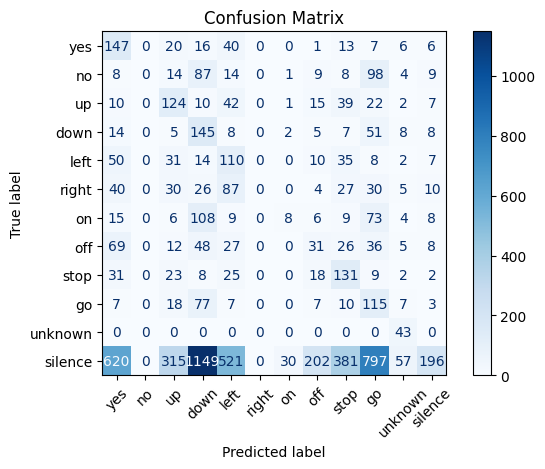

In [35]:
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()